In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

In [115]:
from_date = datetime.datetime(2010, 6, 29) # 1277769600
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_file = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=' + from_date.strftime('%s') + '&period2=' + today.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/tsla_HistoricalData.csv'
max_age = datetime.timedelta(days=1)
if not os.path.exists(local_file) or today - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)
df = pd.read_csv(csv_file, encoding='cp1252', usecols=['Date', 'Adj Close'])


In [116]:
df.rename(columns={'Price': 'Pre-split Price'}, inplace=True)
df.rename(columns={'Adj Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [117]:
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
dfTargets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfTargets = dfTargets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfTargets.columns = dfTargets.columns.str.strip()
# Remove leading/trailing white spaces from data
dfTargets = dfTargets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
dfTargets['Date'] = pd.to_datetime(dfTargets['TargetDate'],dayfirst=True)
dfTargets['ForecastDate'] = pd.to_datetime(dfTargets['ForecastDate'],dayfirst=True)
dfTargets.set_index('Date', inplace=True)
dfTargets = dfTargets.sort_index()
#print(dfOther.columns)


In [118]:
def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

# 5-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2022-08-25', 3), axis=1)

dfTargets.head()

,Year,Source,Bear,Base,Bull,ForecastDate,TargetDate,Note,Link
Date,,,,,,,,,
2022-12-31,2022,SMR,434.000000,666.000000,NaN,2022-03-21,31/12/2022,"1998 weighted average PT, although 1713 is bas...",[Link](https://www.youtube.com/watch?v=W0OKbs_...
2023-06-01,2023,ARKInvest,49.066667,160.266667,276.4,2018-08-22,1/06/2023,'Dear Elon: An Open Letter Against Taking Tesl...,[ARK Invest](https://ark-invest.com/articles/a...
2023-12-31,2023,SMR,715.666667,1148.333333,NaN,2022-03-21,31/12/2023,"given these all forecast at same time, plot th...",NaN
2023-12-31,2023,InvestA,NaN,336.000000,NaN,2023-03-31,31/12/2023,"MODIFIED breakdown using bot, semi, insurance ...",[Link](https://www.youtube.com/watch?v=3stat7u...
2023-12-31,2023,RKirk,NaN,400.000000,NaN,2023-06-23,31/12/2023,8 EPS * 50 = PT $400. Does not include robotax...,[Link](https://www.youtube.com/watch?v=Y-n-3re...


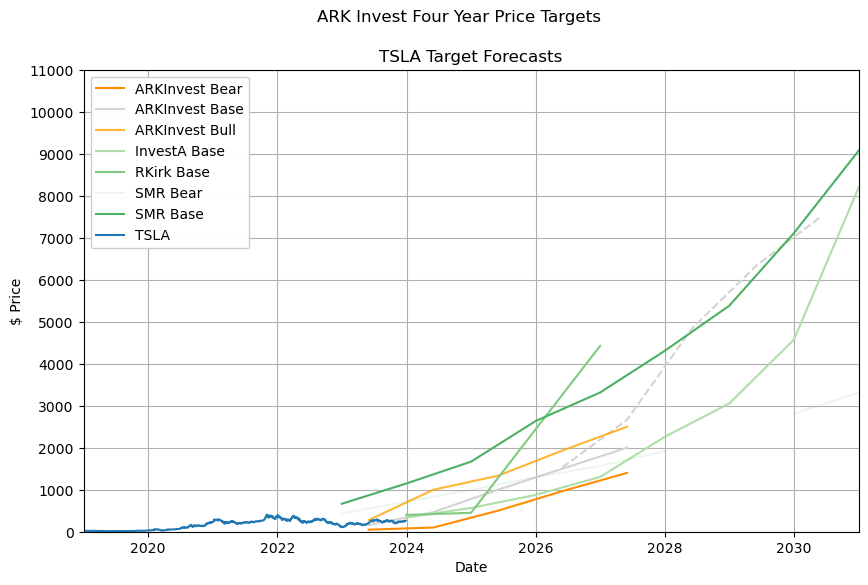

In [119]:
import matplotlib.cm as cm
import numpy as np

# Extend the four year forecast to the end of the data
extendFourYear = True
# Show other forecasts (in addition to ARK)
showOther = True

if not showOther:
    dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

plt.figure(figsize=(10, 6))
grouped = dfTargets.groupby('Source')
colorGreen = plt.cm.Greens(np.linspace(0.2, 0.6, len(grouped)))
colorOrange = plt.cm.Oranges(np.linspace(0.2, 0.6, len(grouped)))

# ARK has multiple forward projections on this date and I want this as a forked dashed line
# to indicate that this was a continuation of a forecast
# This is temporary until I can find a better way to plot muliple projections from one source
forecast_date = pd.to_datetime('2022-04-14')  

for (source, group), colorGreen in zip(grouped, colorGreen):
    if group['Bear'].notna().sum() > 1: # Check if the group has more than one non-null value
        if source == 'ARKInvest':
            plot_color='darkorange'
            plot_alpha=1
        else:
            plot_color=colorGreen
            plot_alpha=0.1
        plt.plot(group.index, group['Bear'], label=source+' Bear', color=plot_color, alpha=plot_alpha)

    if source == 'ARKInvest':
        plot_color = 'lightgrey'
    else:
        plot_color = colorGreen

    subgroup = group[group['ForecastDate'] == forecast_date]
    if not subgroup.empty:      
        plt.plot(subgroup.index, subgroup['Base'], color=plot_color, linestyle='--')
    subgroup = group[group['ForecastDate'] != forecast_date]
    if not subgroup.empty:      
        plt.plot(subgroup.index, subgroup['Base'], label=source+' Base', color=plot_color)

    if group['Bull'].notna().sum() > 1: #.any():  # Check if the group has any non-null values
        plt.plot(group.index, group['Bull'], label=source+ ' Bull', color='orange', alpha=0.8)


colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Price'], color=colors[0]['color'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('$ Price')
plt.suptitle('ARK Invest Four Year Price Targets')
plt.title('TSLA Target Forecasts')
plt.yticks(range(0, 100000, 1000))
plt.grid(True)

if extendFourYear:
    right_limit = pd.to_datetime('2031-01-01')
    top_limit = 11000
else:
    right_limit = pd.to_datetime('2028-01-01')
    top_limit = 5000
plt.ylim(bottom=0, top=top_limit) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=right_limit)

#plt.yscale('linear')
legend = plt.legend(loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()

### Disclaimer

Not financial advice: All content of this repository is for educational purposes only. No warranty or guarantee or forward looking statements of fit for purpose; do your own research, etc.